In [1]:
import pandas as pd
import geopandas as gp

%pylab inline
import matplotlib.pyplot as plt

import os
import pickle

from scipy.cluster.vq import kmeans2
import Pycluster


Populating the interactive namespace from numpy and matplotlib


In [2]:
def nColors(k=2, cmap='spectral'):

    from pylab import get_cmap
    
    if type(cmap) == str:
        cm = get_cmap(cmap)
        colors = [cm(1.*i/(k-1)) for i in range(k)]
    elif cmap==None:
        colors = ['k']
    else:
        colors = cmap
        
    return colors
    

In [3]:
def clusterAndPlot(df,k, height=10, engine='PyCluster', cmap='spectral'):
    '''calculate and plot kmean clustering'''
    fig, axes = plt.subplots(k+1, figsize=(18,height), sharex='all', sharey='all')
    
    if engine == 'scipy':
        centroids, label = kmeans2(df, k, iter=100, thresh=1e-05)
    else:
        labels, error, nfound = Pycluster.kcluster(df, k)
    df['label'] = labels
    
    
    colors = nColors(k=k, cmap=cmap)
        
    #one by one
    for l, g in df.groupby('label'):
        g.T.plot(ax=axes[l], legend=0, c=colors[l],alpha=.2)
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
        pd.Series(g.mean(0)).plot(ax=axes[-1], label='cluster %d'% (l ), c=colors[l])
        
    #     plt.legend()
    return df

In [4]:
def normaliseTimeseries(df, transpose=True):
    '''transpose and normilize timeseries by themself
       removing the median and dividing by sdt'''
    
    if transpose:
        df = df.T
    
    return (df - df.mean(0))/df.std(0)
    

In [5]:
def averageWeek(df, ax, tcol='ts', ccol='id', label=None, treshold=0, normalize=True, verbose=False, **kwargs):
    '''calculate average week on ts'''
    
    s = df[[tcol, ccol]].rename(columns={tcol:'ts',ccol:'id'}) # rename to convention
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count').reset_index()
    s['id'] = s['id'].astype(float)


    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg('mean')
    
    
    if not label:
        label = ccol
    
    if s.id.sum() >= treshold:
        
        if normalize:
            sNorm = 1.0*s/s.sum()
        else:
            sNorm = s
        
        sNorm.rename(columns={'id':label}, inplace=1) 
        sNorm.plot(ax=ax, legend=False, **kwargs);

        return sNorm.rename(columns={'id':label})
        
    else:
        if verbose:
            print name, 'didnt pass treshhold:', s['id'].sum()

        pass
    
    

In [6]:
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False, **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))

    weeks = []


    for name, g in df.groupby(attr):
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d' % (title,th), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1, alpha=.5, linewidth=4)

    return data
    
    

## Getting Data

In [7]:
# zipcode maps
zipPath = os.getenv('PWD') + '/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]
print zips.crs

{'init': u'epsg:4326'}


In [8]:
# dataset to cluster
datum = pd.read_pickle(os.getenv('PWD') + '/code/zipJoined.pkl')

In [9]:
d = datum.drop(['tweet', 'lon', 'lat', 'rtwts', 'fvrts','geometry', 'application', 'source', 'timestamp','index_right','user_id'], axis=1)

In [10]:
d.head(2)

id                  ts postalCode
0  550441283261857792 2015-01-01 00:00:03      11420
1  550441288076914688 2015-01-01 00:00:04      10038

(0, 0.15)

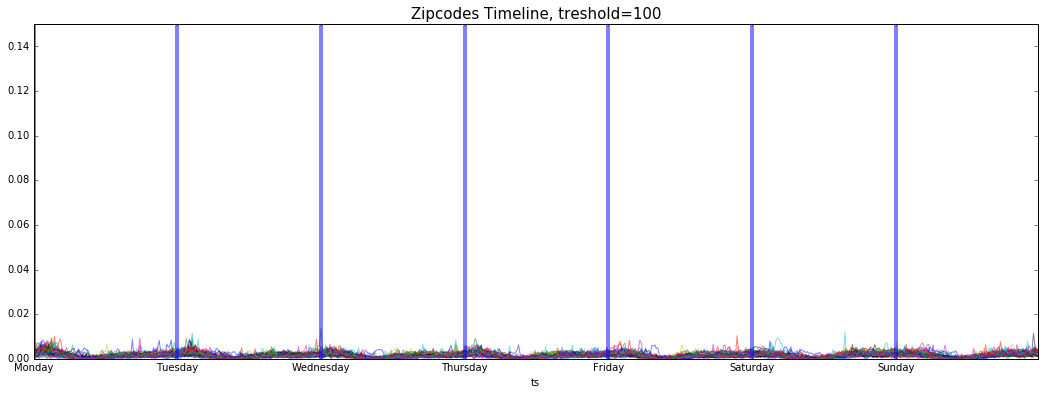

In [11]:
zcodes = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=False, th=100, legend=False)
plt.ylim(0, 0.15)

In [12]:
zcodes.max(0).sort_values(ascending=0).head(3)

11374    0.013855
11369    0.011933
10469    0.011476
dtype: float64

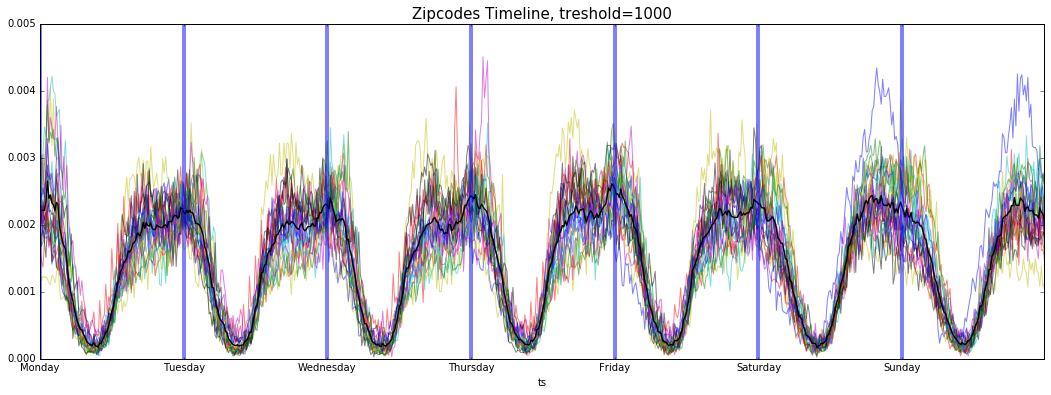

In [13]:
zcodesN = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=True, th=1000, legend=False, normalize=True)

In [14]:
len(set(zcodesN.columns.tolist()))

23

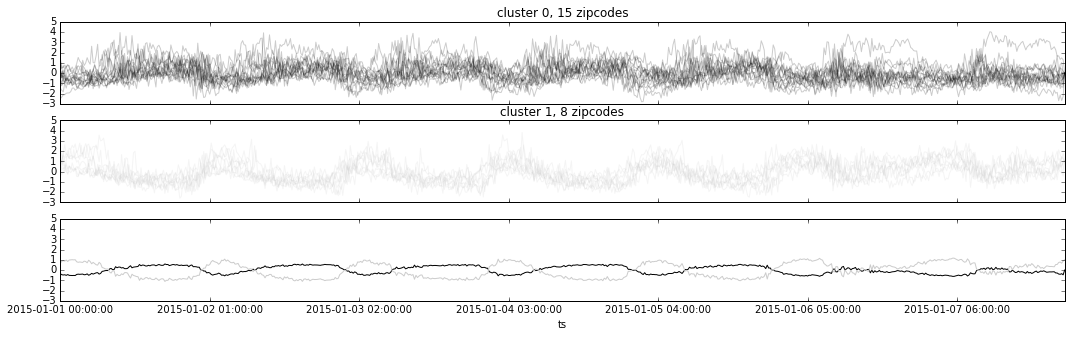

In [15]:
dfLabels = clusterAndPlot(normaliseTimeseries(zcodesN) , 2, height=5)

In [16]:
labels = dfLabels.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labelZip = zips.merge(labels, how='left', on='postalCode')

/Users/casy/anaconda/lib/python2.7/site-packages/geopandas-0.1.0.dev1451292-py2.7.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


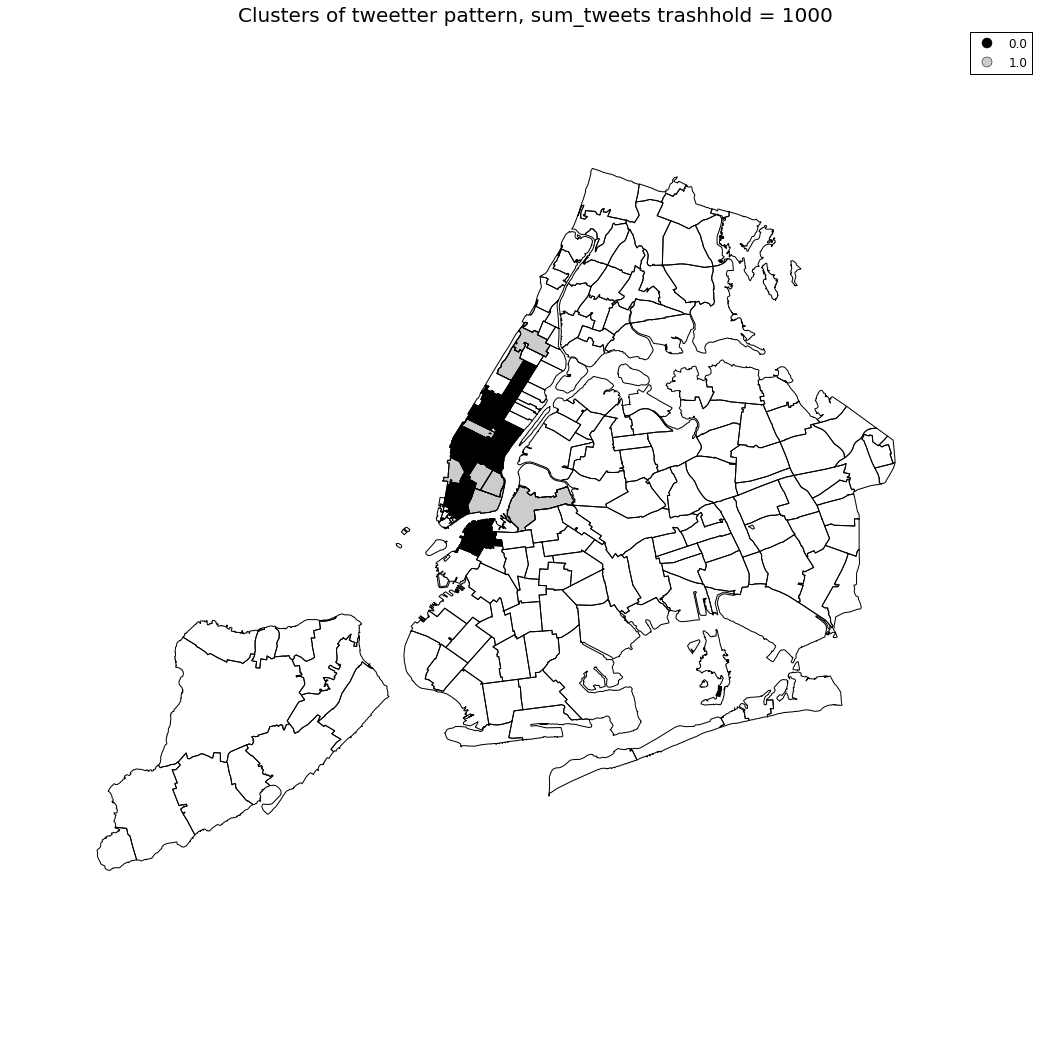

In [17]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip.plot(alpha=0, ax=ax) # empty back
labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
           colormap='spectral', ax=ax,
           alpha=1, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 1000', fontsize=20)
plt.axis('off');

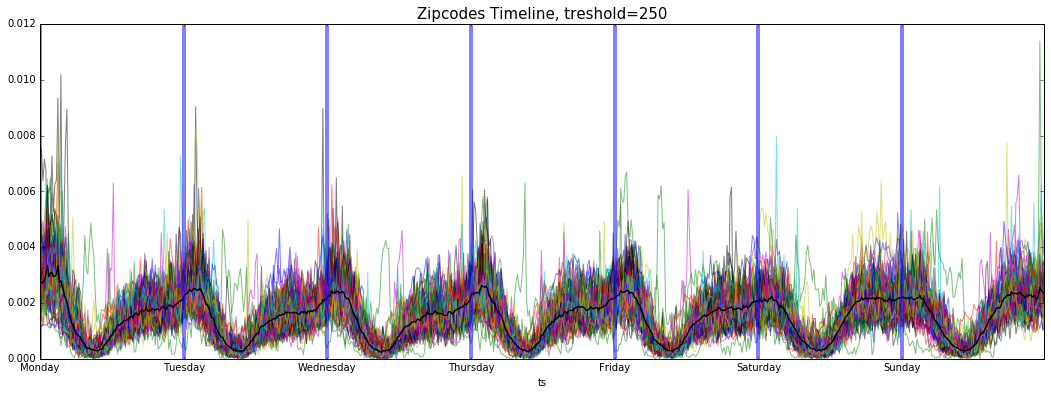

In [14]:
zcodesN250 = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=True, th=250, legend=False, normalize=True)

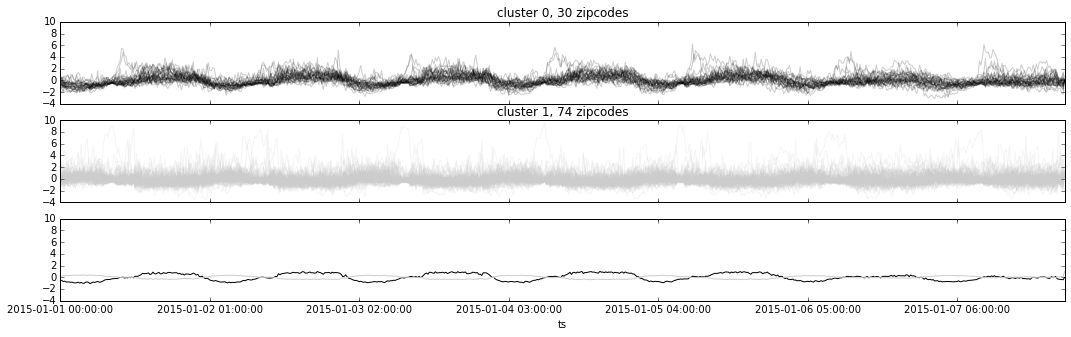

In [21]:
dfLabels250 = clusterAndPlot(normaliseTimeseries(zcodesN250) , 2, height=5)

In [22]:
labels250 = dfLabels250.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labelZip250 = zips.merge(labels250, how='left', on='postalCode')

/Users/casy/anaconda/lib/python2.7/site-packages/geopandas-0.1.0.dev1451292-py2.7.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


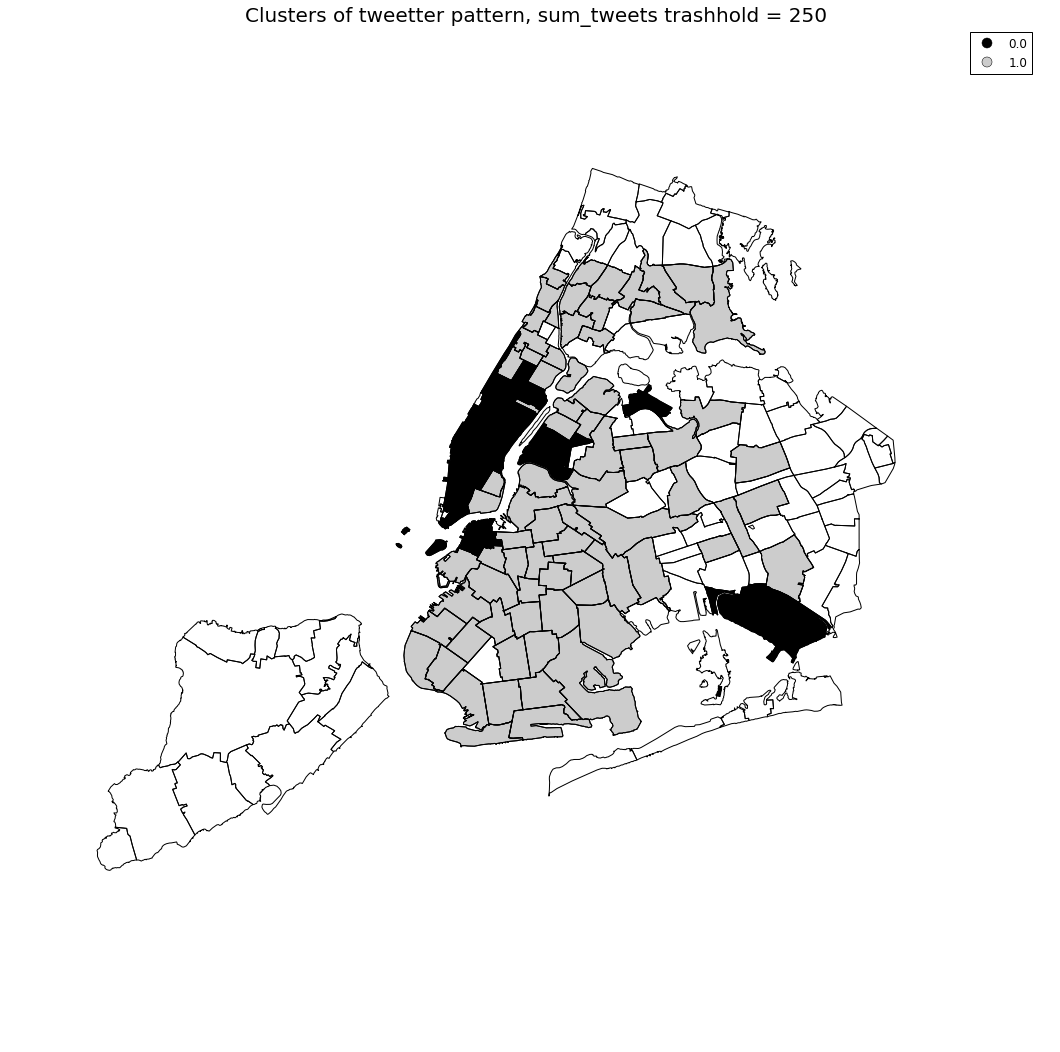

In [23]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip250.plot(alpha=0, ax=ax) # empty back
labelZip250[pd.notnull(labelZip250.label)].plot(column='label', categorical=1,
           colormap='spectral', ax=ax,
           alpha=1, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
plt.axis('off');

In [15]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [42]:
X = normaliseTimeseries(zcodesN250)
A = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15)

In [43]:
af = A.fit(X)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [44]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 12
Silhouette Coefficient: 0.057


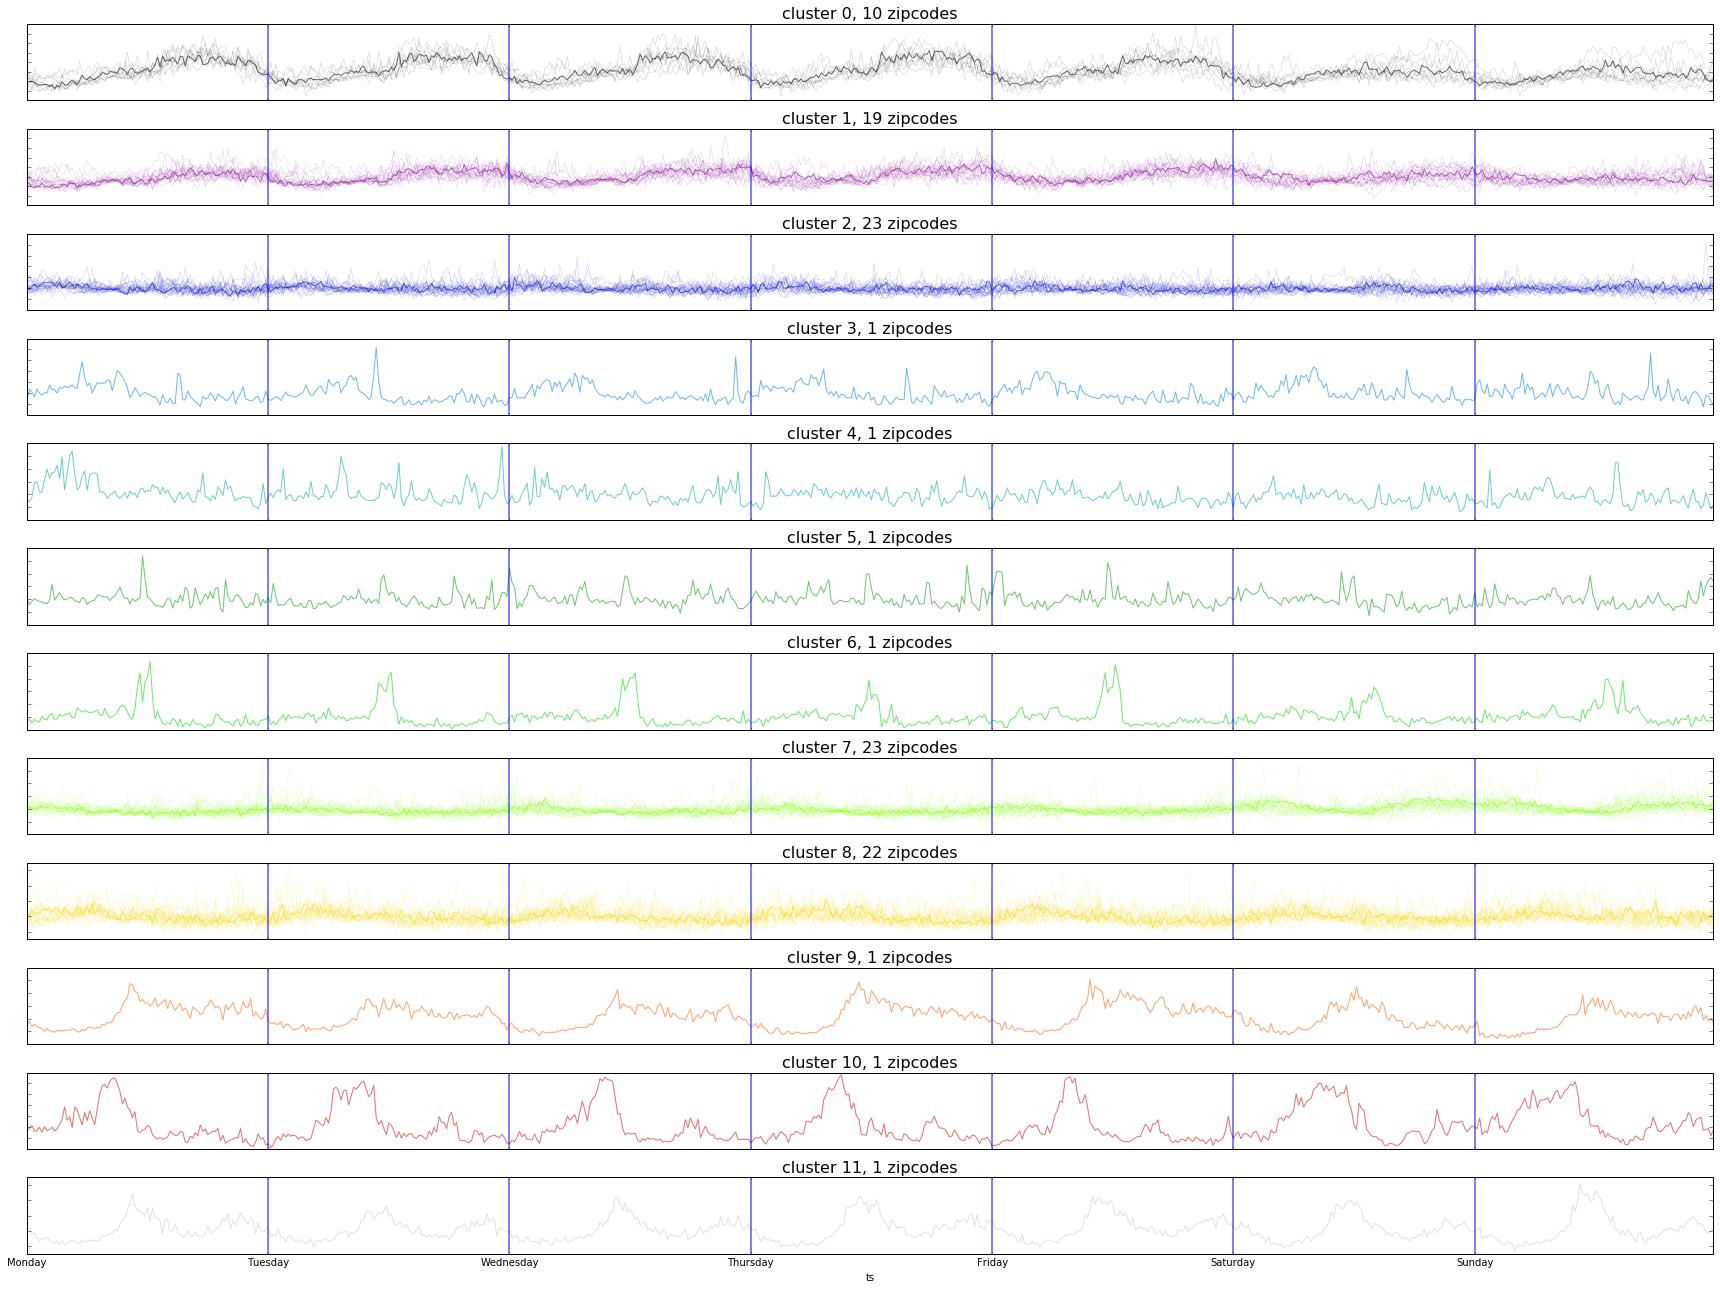

In [45]:
fig, axes = plt.subplots(n_clusters_, figsize=(24,18), sharex='all')

colors = nColors(k=n_clusters_, cmap='spectral')
ticks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    

for k, col in zip(range(n_clusters_), colors):    
    X.iloc[cluster_centers_indices[k],:].plot(lw=1, c=col, label=k, alpha=.5, ax=axes[k])
    X[labels==k].T.plot(lw=.5, c=col,alpha=0.2, ax=axes[k], legend=0)
    axes[k].set_title('cluster %d, %d zipcodes' % (k, len(X[labels==k])), fontsize=16)
    
    axes[k].set_xticklabels([],minor=False) # the default
    axes[k].set_xticklabels(ticks,minor=True)
    axes[k].set_yticklabels([],minor=False) 
    
    for d in dates:
        axes[k].axvline(x=d, ymin=0, ymax=1, alpha=.5, linewidth=2)



    
plt.tight_layout()

In [46]:
len(labels)

104

In [47]:
result = zcodesN250.T
result['label'] = labels
result.reset_index(inplace=1)
result.rename(columns={'index':'postalCode'},inplace=1)

# result.head(2)
r = result[['postalCode','label']]
labelZip = zips.merge(r, how='left', on='postalCode')

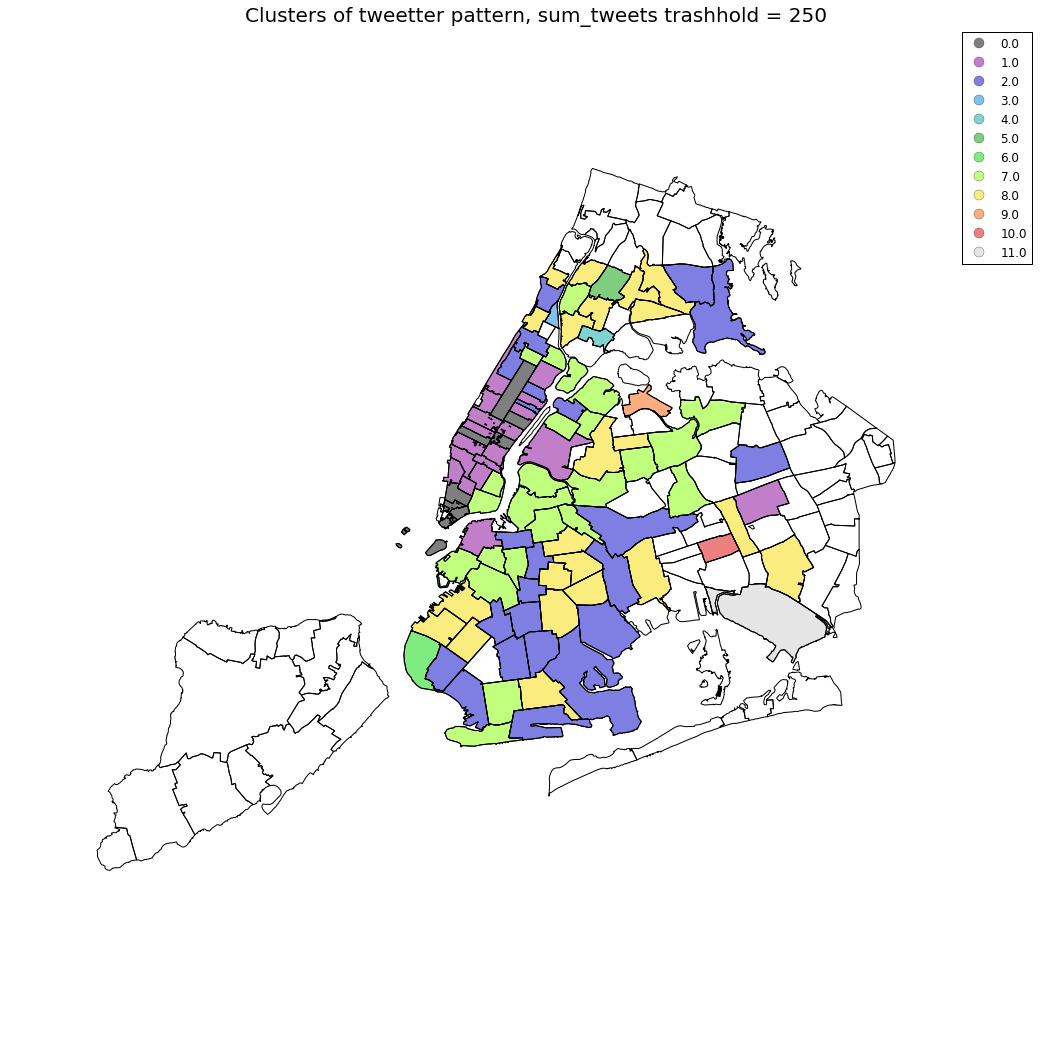

In [48]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip.plot(alpha=0, ax=ax) # empty back
labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
                                          colormap='spectral', ax=ax,
                                          alpha=.5, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
plt.axis('off');

In [49]:
labelZip.to_csv('total_partition250.csv')

## App clustering

In [23]:
datum.application.value_counts().head(15)

Twitter for iPhone             2435349
Instagram                      1353029
Twitter for Android             580972
Foursquare                      272112
Twitter for iPad                 89511
dlvr.it                          68478
Tweetbot for iΟS                 29389
Squarespace 6                    24761
iOS                              22517
Twitter for Android Tablets      22240
Twitter for Windows Phone        16390
511NY-Tweets                     15559
COS App                          13120
Untappd                          12531
SimplyCast                        7256
Name: application, dtype: int64

In [24]:
def getAppTS(data, app='Instagram', th=250):
    d = data[data.application == app]
    
    return bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline, %s' % app, \
                     av=True, th=th, legend=False, normalize=True)
    

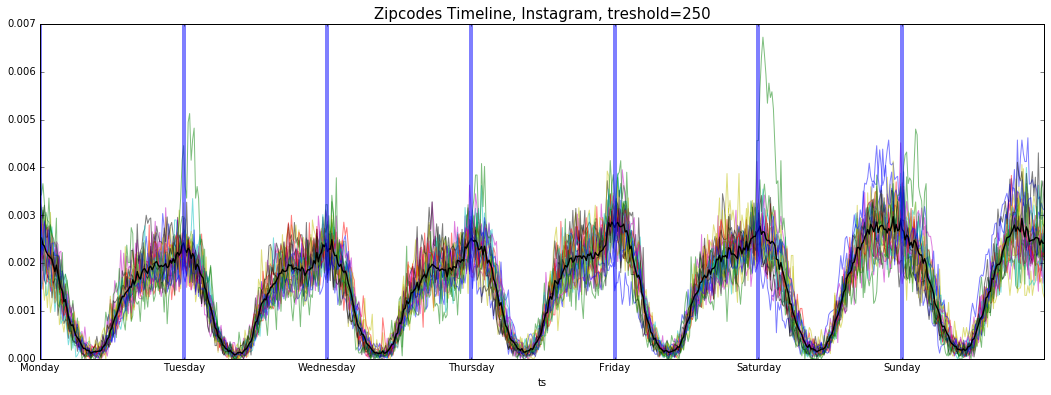

In [25]:
InstN250 = getAppTS(datum, app='Instagram', th=250)

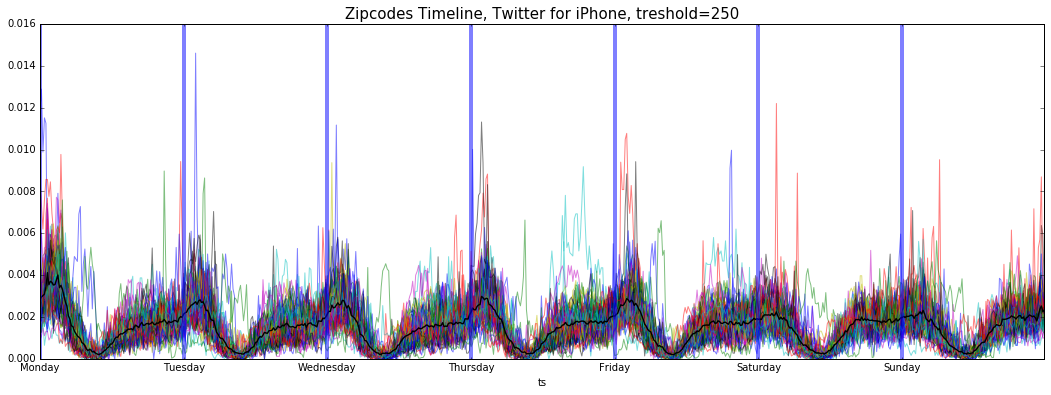

In [26]:
TwIphoneN250 = getAppTS(datum, app='Twitter for iPhone', th=250)

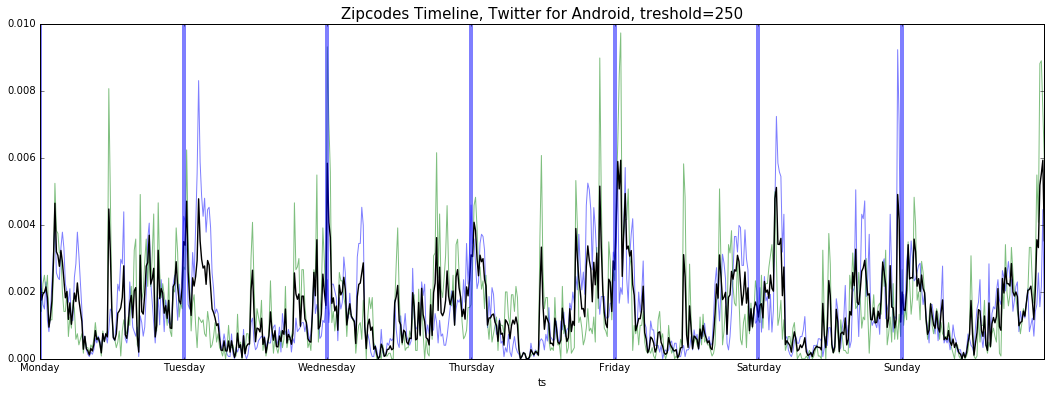

In [27]:
TwAndroidN250 = getAppTS(datum, app='Twitter for Android', th=250)

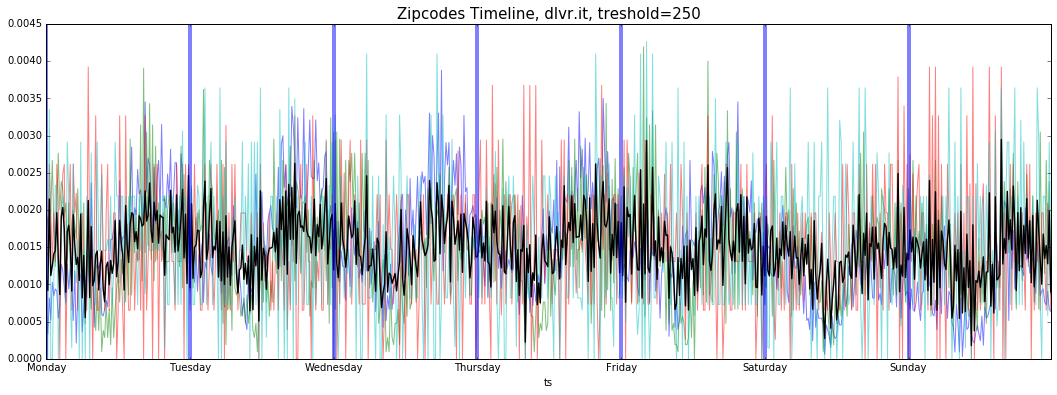

In [28]:
DeliverrN250 = getAppTS(datum, app='dlvr.it', th=250)

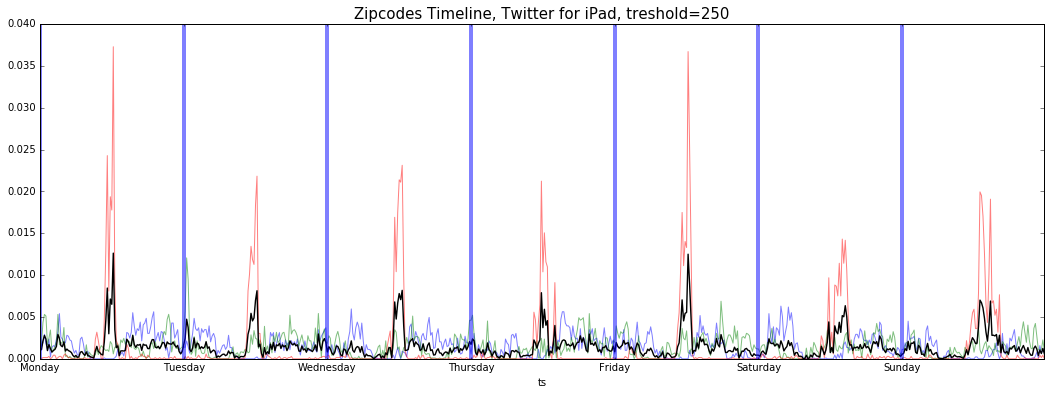

In [29]:
IpadN250 = getAppTS(datum, app='Twitter for iPad', th=250)

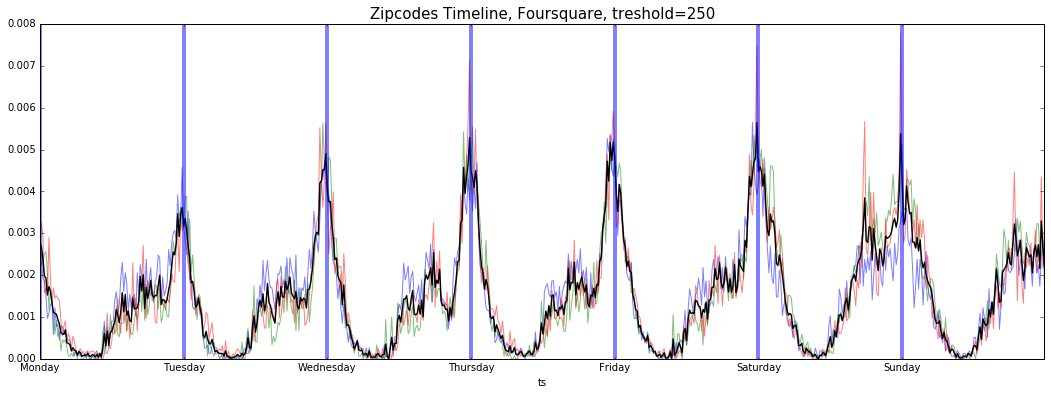

In [30]:
FoursquareN250 = getAppTS(datum, app='Foursquare', th=250)

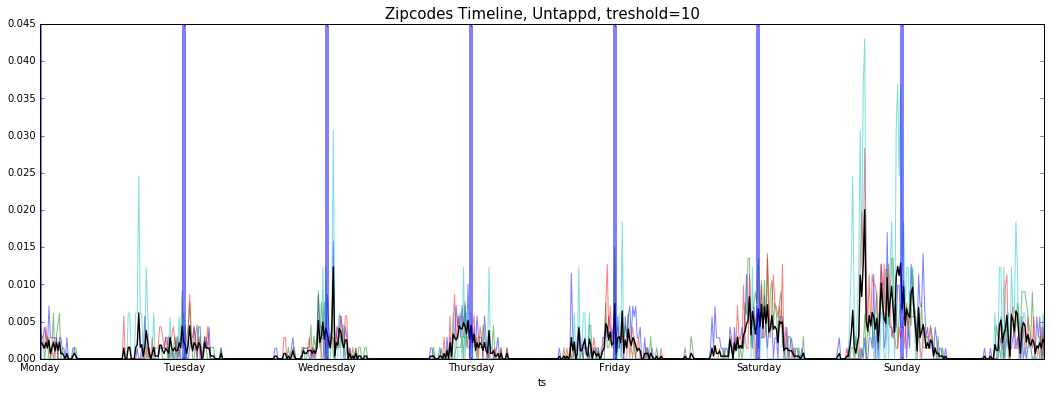

In [31]:
UntappdN250 = getAppTS(datum, app='Untappd', th=10)

## Instagram TS clustering

In [32]:
def affinityClustering(data):
    X = normaliseTimeseries(data)
    A = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15)
    
    
    af = A.fit(X)

    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels, metric='sqeuclidean'))
    
    fig, axes = plt.subplots(n_clusters_, figsize=(24,10), sharex='all')

    colors = nColors(k=n_clusters_, cmap='spectral')
    ticks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    

    for k, col in zip(range(n_clusters_), colors):    
        X.iloc[cluster_centers_indices[k],:].plot(lw=1, c=col, label=k, alpha=.5, ax=axes[k])
        X[labels==k].T.plot(lw=.5, c=col,alpha=0.2, ax=axes[k], legend=0)
        axes[k].set_title('cluster %d, %d zipcodes' % (k, len(X[labels==k])), fontsize=16)

        axes[k].set_xticklabels([],minor=False) # the default
        axes[k].set_xticklabels(ticks,minor=True)
        axes[k].set_yticklabels([],minor=False) 

        for d in dates:
            axes[k].axvline(x=d, ymin=0, ymax=1, alpha=.5, linewidth=2)


    plt.tight_layout()
    
    result = data.T
    result['label'] = labels
    result.reset_index(inplace=1)
    result.rename(columns={'index':'postalCode'},inplace=1)

    # result.head(2)
    r = result[['postalCode','label']]
    labelZip = zips.merge(r, how='left', on='postalCode')
    return labelZip
    

In [33]:
def plotTSCLusters(labelZip):
    fig, ax = plt.subplots(figsize=(18,18))

    labelZip.plot(alpha=0, ax=ax) # empty back
    labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
                                              colormap='spectral', ax=ax,
                                              alpha=.5, legend=True)

    plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
    plt.axis('off');

Estimated number of clusters: 5
Silhouette Coefficient: 0.162


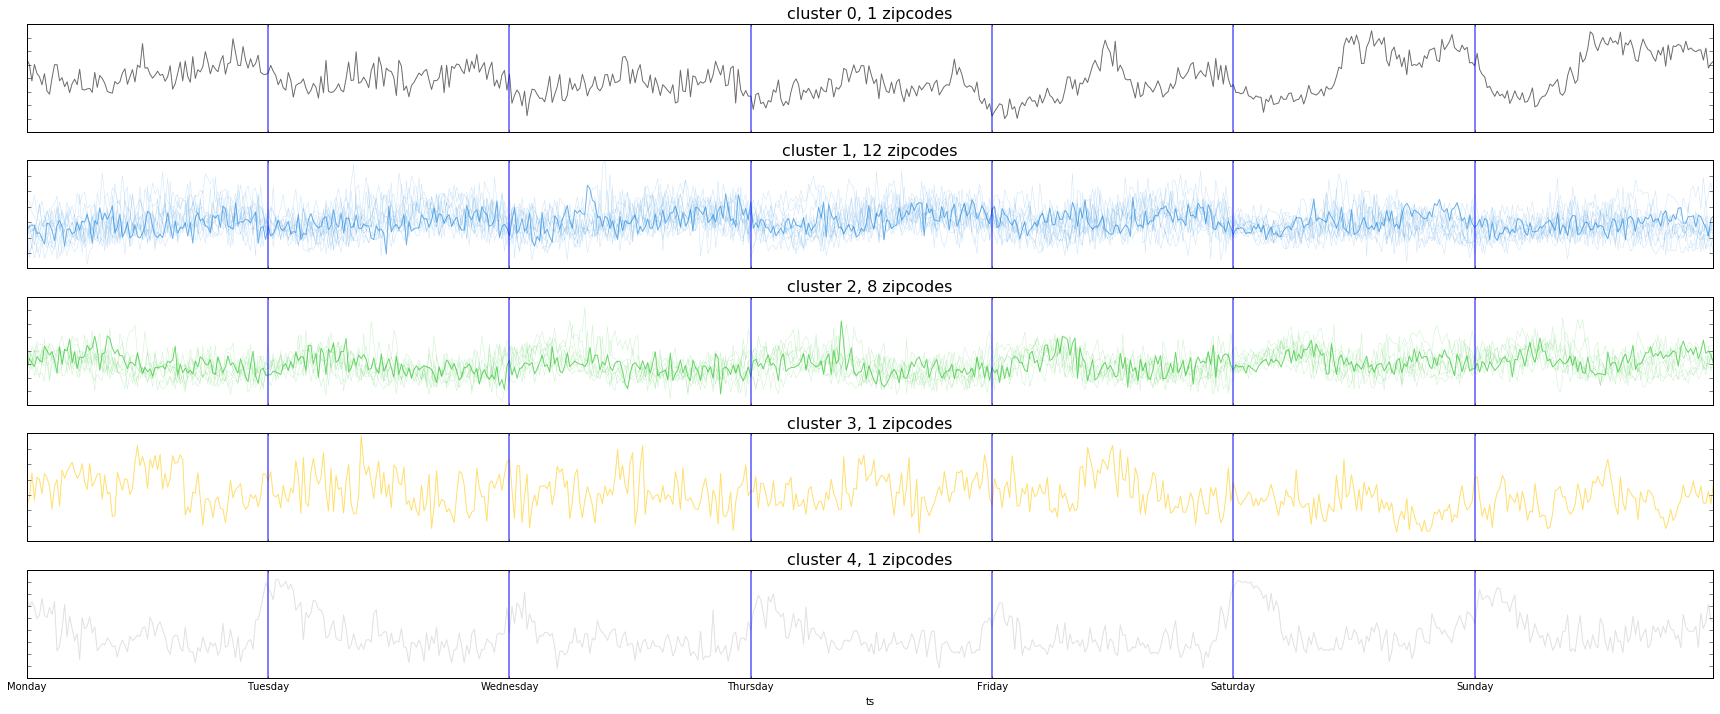

In [37]:
labelZip = affinityClustering(InstN250)

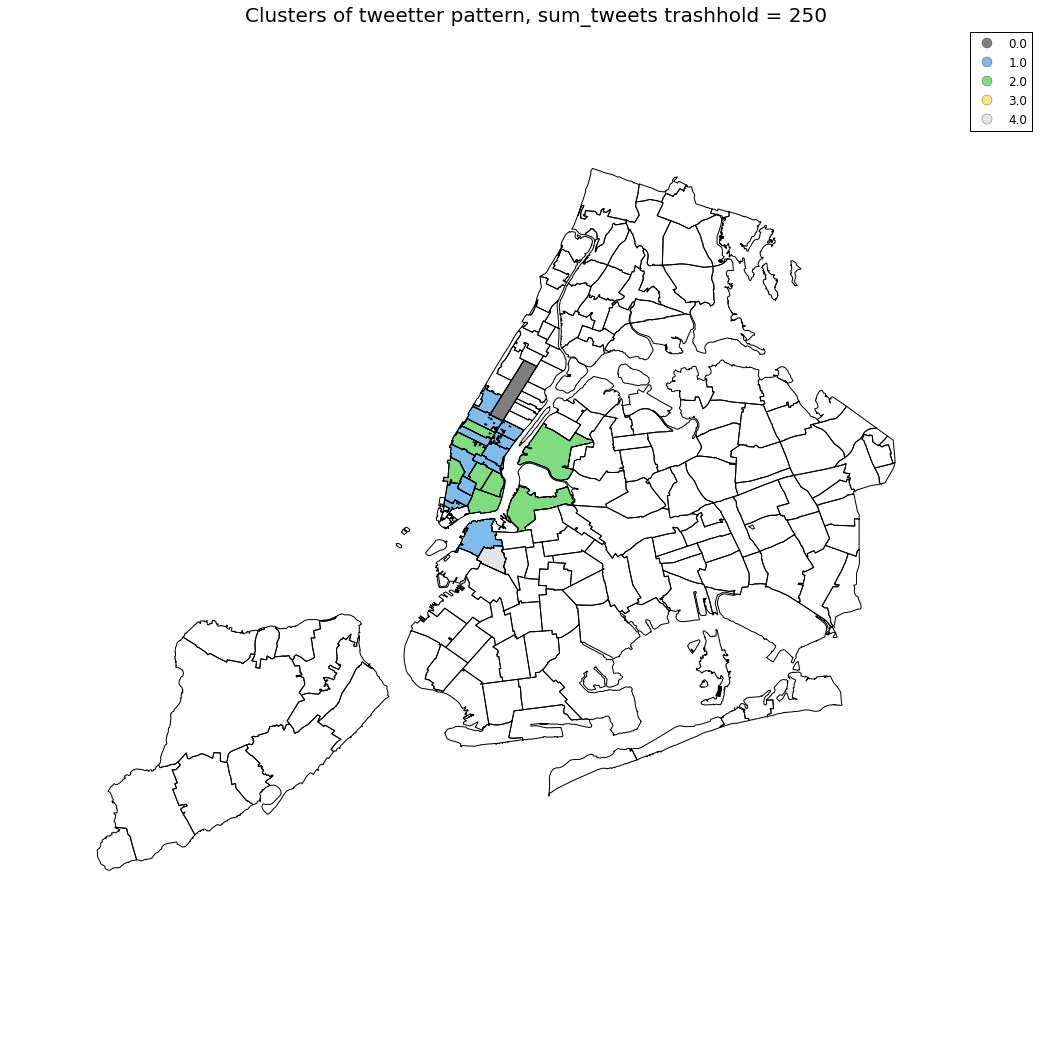

In [38]:
# % matplotlib notebook
plotTSCLusters(labelZip)

## Iphone Clustering

Estimated number of clusters: 8
Silhouette Coefficient: 0.199


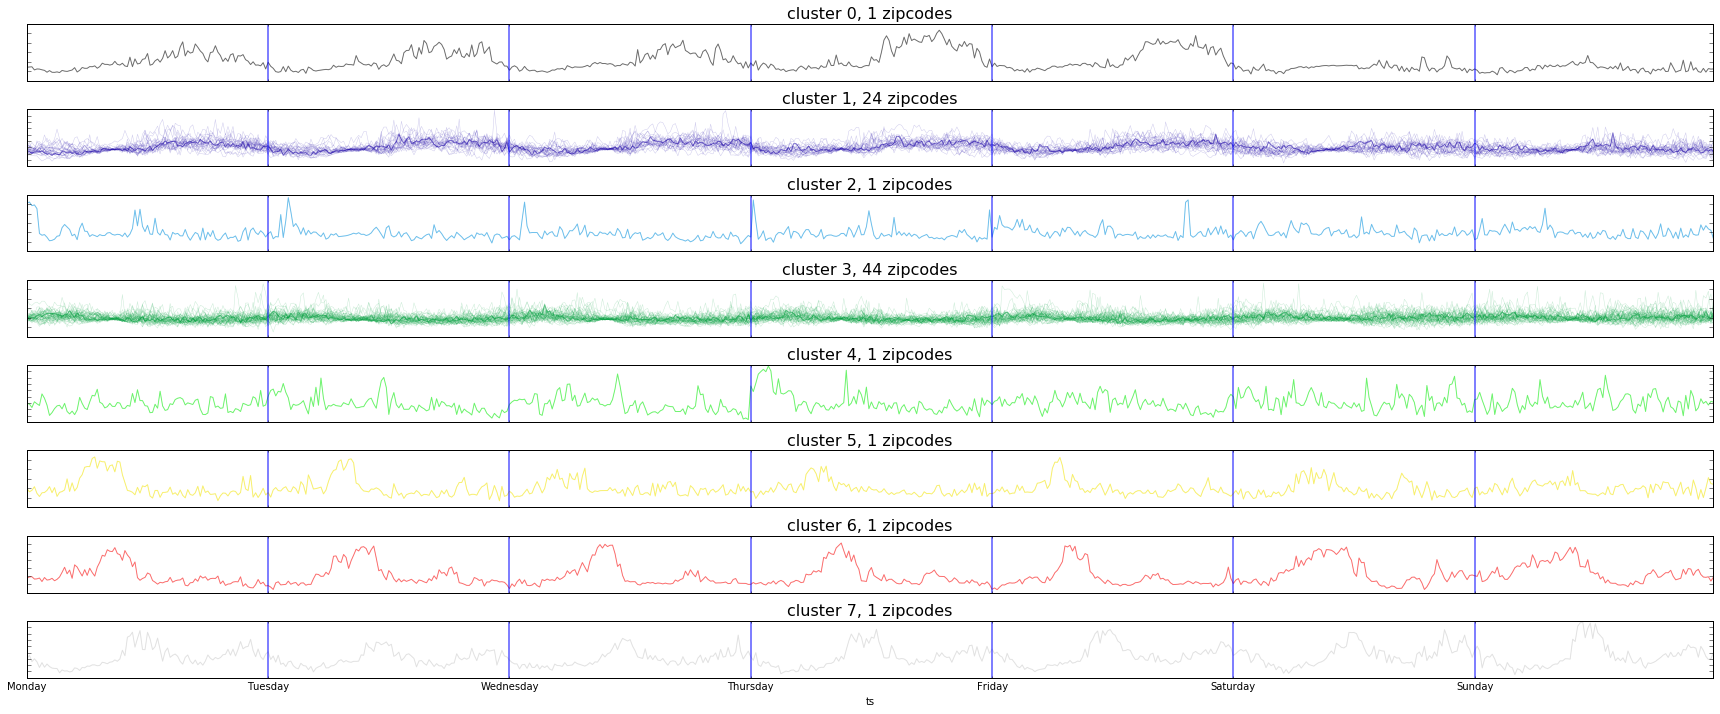

In [84]:
labelZip = affinityClustering(TwIphoneN250)

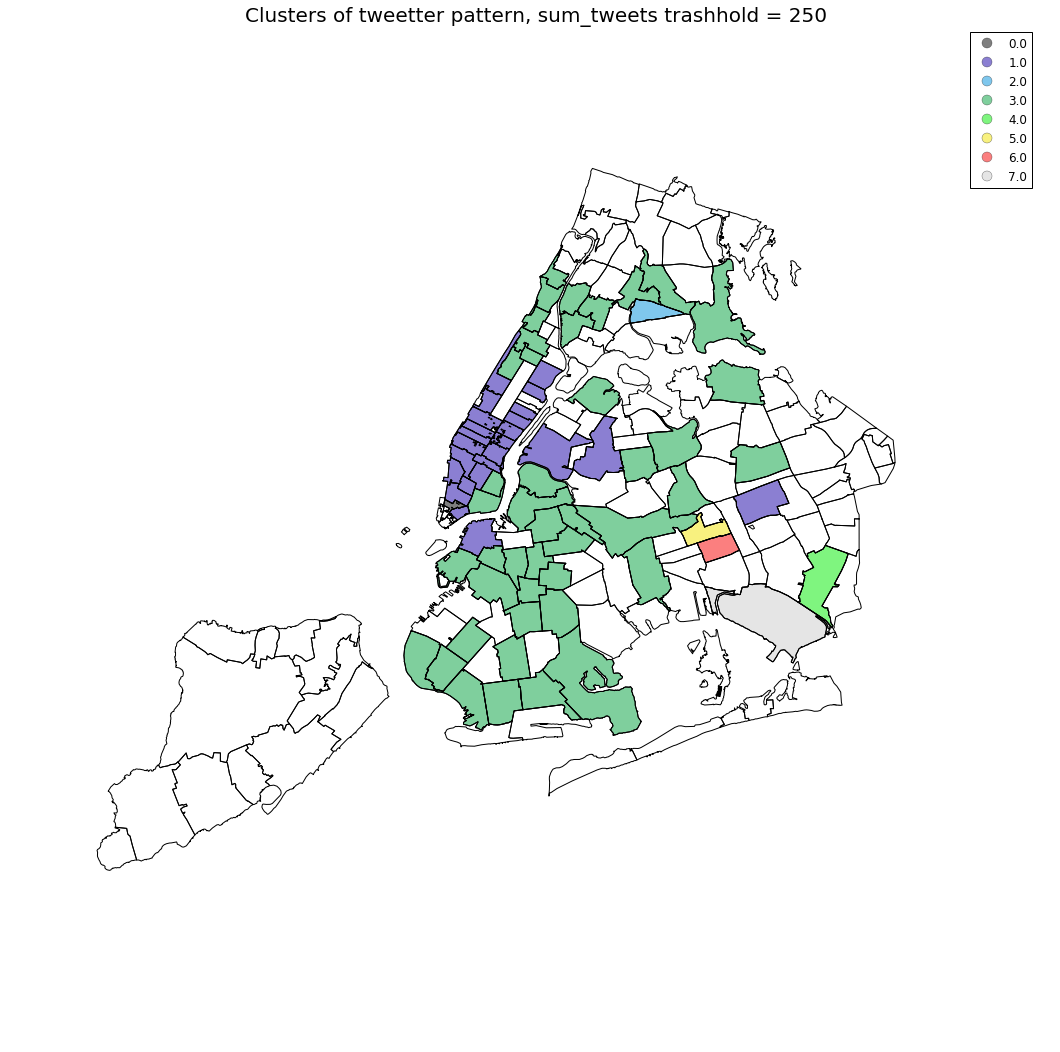

In [85]:
plotTSCLusters(labelZip)

## Cluster demographics

In [39]:
labelZip.to_csv('instagram_partition250.csv')

In [41]:
from demographics import dem, compare

ImportError: No module named demographics

## cluster apps means